# Mini Projeto - Rede Neural com TensorFlow Para Classificação de Imagens de Vestuário

Neste projeto vamos construir uma rede neural artificial com TensorFlow para classificação de imagens, especificamente classificação de imagens de roupas e acessórios.

## Instalando e carregando os pacotes

In [1]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Configuração de gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Para tornar a saída deste notebook estável em todas as execuções
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Aqui definimos os diretórios onde salvaremos as imagens
PROJECT_ROOT_DIR = "."
PROJECT_NUM = "Mini-Projeto5"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "dados", PROJECT_NUM)
os.makedirs(IMAGES_PATH, exist_ok = True)

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas    : 1.5.3
keras     : 2.15.0
tensorflow: 2.15.0
numpy     : 1.25.2
matplotlib: 3.7.1



## Carregando e preparando os dados

Vamos começar carregando o conjunto de dados Fashion MNIST com artigos de moda masculina e feminina. O Keras possui várias funções para carregar conjuntos de dados populares no `keras.datasets`. O conjunto de dados já está dividido para você entre um conjunto de treinamento e um conjunto de testes, mas pode ser útil dividir ainda mais o conjunto de treinamento para ter um conjunto de validação.

In [5]:
# Carregando o dataset
fashion_mnist = keras.datasets.fashion_mnist

In [6]:
# Extraímos os dados de treino e teste
(X_treino_full, y_treino_full), (X_teste, y_teste) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


O conjunto de treinamento contém 60.000 imagens em escala de cinza, cada uma com 28x28 pixels:

In [7]:
# Shape
X_treino_full.shape

(60000, 28, 28)

Cada intensidade de pixel é representada como um byte (0 a 255):

In [9]:
# Tipo de dados
X_treino_full.dtype

dtype('uint8')

Vamos dividir o conjunto de treinamento completo em um conjunto de validação e um conjunto de treinamento (menor). Também dimensionamos as intensidades de pixel para o intervalo de 0-1 (padronização) e as convertemos em float, dividindo por 255.

In [10]:
# Preparação dos dados
X_valid, X_treino = X_treino_full[:5000] / 255., X_treino_full[5000:] / 255.
y_valid, y_treino = y_treino_full[:5000], y_treino_full[5000:]
X_teste = X_teste / 255.

Podemos plotar uma imagem usando a função `imshow ()` do Matplotlib, com um mapa de cores **binary**.

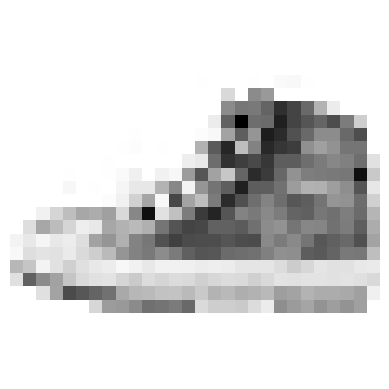

In [13]:
# Plot de uma imagem
plt.imshow(X_treino[2], cmap = "binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como uint8), de 0 a 9:

In [15]:
# Labels (dados de saída) de treino
y_treino

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Aqui estão os nomes de classe correspondentes:

In [16]:
# Nomes das classes
nomes_classes = ["T-shirt/top",
                 "Trouser",
                 "Pullover",
                 "Dress",
                 "Coat",
                 "Sandal",
                 "Shirt",
                 "Sneaker",
                 "Bag",
                 "Ankle boot"]

Mais detalhes do dataset aqui: https://www.tensorflow.org/datasets/catalog/fashion_mnist

Portanto, a primeira imagem no conjunto de treinamento é um casaco:

In [17]:
# Nome de classe
nomes_classes[y_treino[0]]

'Coat'

O conjunto de validação contém 5.000 imagens e o conjunto de testes contém 10.000 imagens:

In [19]:
# Shape
X_valid.shape

(5000, 28, 28)

In [20]:
# Shape
X_teste.shape

(10000, 28, 28)

Vamos dar uma olhada em uma amostra das imagens no conjunto de dados.

In [21]:
# Função para salvar as imagens
def salva_imagem(fig_id, tight_layout = True, fig_extension = "png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Salvando a imagem...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

Salvando a imagem... plot_fashion_mnist


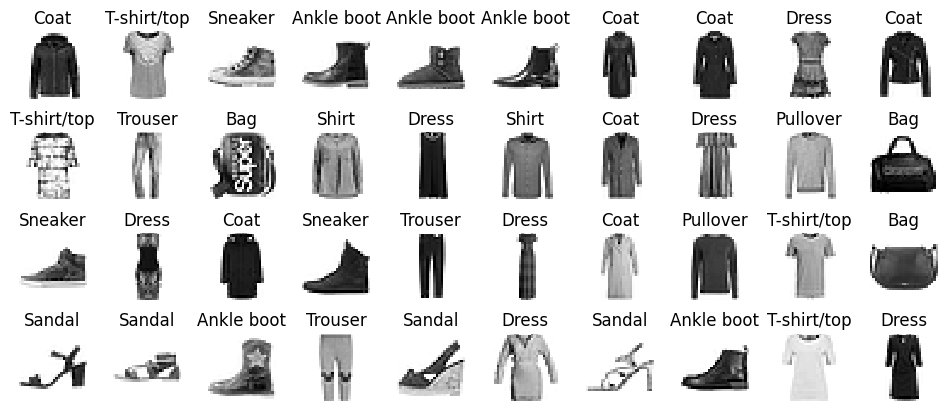

In [22]:
# Plot de algumas imagens

# Vamos plotar 4 linhas e 10 coluns
n_rows = 4
n_cols = 10

# Área de plotagem
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

# Loop pelas linhas e colunas
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_treino[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(nomes_classes[y_treino[index]], fontsize = 12)

# Ajusta os plots
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

# Salva a imagem em disco
salva_imagem('plot_fashion_mnist', tight_layout = False)

# Mostra a imagem
plt.show()

Os dados estão prontos. Vamos construir e treinar o modelo.

## Construção do Modelo

In [23]:
# Modelo de Rede Neural com 2 Camadas Densas

# Cria o objeto do tipo sequência
modelo = keras.models.Sequential()

# Camada para receber os dados de entrada
modelo.add(keras.layers.Flatten(input_shape = [28, 28]))

# Primeira camada oculta com ativação relu
modelo.add(keras.layers.Dense(300, activation = "relu"))

# Segunda camada oculta com ativação relu
modelo.add(keras.layers.Dense(100, activation = "relu"))

# Camada de saída com ativação softmax
# Teremos uma probabilidade prevista para cada classe
modelo.add(keras.layers.Dense(10, activation = "softmax"))

In [24]:
# Limpamos a sessão Keras e
keras.backend.clear_session()

In [25]:
# Camadas do modelo
modelo.layers

In [26]:
# Sumário do modelo
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


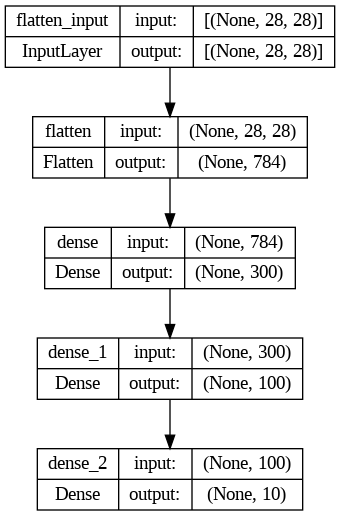

In [27]:
# Vamos criar um plot com o modelo completo e salvar a imagem em disco
keras.utils.plot_model(modelo, IMAGES_PATH + "/modelo_fashion_mnist.png", show_shapes = True)

In [28]:
# Vamos nomear a primeira camada oculta do modelo
hidden1 = modelo.layers[1]
hidden1.name

'dense'

In [29]:
# Verificamos se a camada com novo nome existe
modelo.get_layer(hidden1.name) is hidden1

True

In [30]:
# Extraímos pesos e bias da primeira camada oculta
weights, biases = hidden1.get_weights()

In [31]:
# Pesos que serão usados no começo do treinamento e são gerados de forma aleatória pelo Keras/TensorFlow
weights

array([[ 5.0839335e-03,  4.3201596e-03, -3.8905181e-02, ...,
        -2.0165242e-02,  1.6747795e-02, -2.3504023e-02],
       [-2.6822776e-02, -6.1221495e-02, -7.4113190e-02, ...,
         3.5125226e-02, -8.0104172e-03, -1.2187004e-02],
       [ 5.5903807e-02,  2.9835284e-02,  3.5332814e-02, ...,
        -4.4568308e-02, -4.6769630e-02,  7.1467534e-02],
       ...,
       [-4.4625070e-02,  6.9790646e-02, -1.3578542e-02, ...,
        -7.2374195e-04,  5.3243339e-02, -6.2428042e-03],
       [-7.3598221e-02, -4.1668683e-02,  4.7086604e-02, ...,
         3.0820712e-02,  3.8983881e-02, -1.2524426e-05],
       [-1.7465416e-02,  5.7347104e-02,  3.3735394e-02, ...,
         4.7790535e-02, -1.8527046e-02, -1.4763907e-02]], dtype=float32)

In [32]:
# Shape
weights.shape

(784, 300)

In [33]:
# Bias que serão usados no começo do treinamento
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
# Shape
biases.shape

(300,)

In [35]:
# Agora compilamos o modelo com o otimizador, função de custo e a métrica
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
modelo.compile(optimizer = "sgd", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Podemos então treinar o modelo.

In [37]:
# Treinamento
history = modelo.fit(X_treino,
                     y_treino,
                     epochs = 10,
                     validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4587 - accuracy: 0.8395 - val_loss: 0.4402 - val_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4266 - accuracy: 0.8504 - val_loss: 0.4019 - val_accuracy: 0.8610
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4039 - accuracy: 0.8581 - val_loss: 0.4769 - val_accuracy: 0.8234
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3871 - accuracy: 0.8637 - val_loss: 0.3768 - val_accuracy: 0.8682
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3739 - accuracy: 0.8697 - val_loss: 0.3633 - val_accuracy: 0.8732
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3589 - accuracy: 0.8737 - val_loss: 0.3600 - val_accuracy: 0.8756
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3488 - accuracy: 0.8767 - val_loss: 0.3572 - val_accuracy:

In [38]:
#  Hiperparâmetros do modelo
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1719}

In [39]:
# Aqui estão as métricas disponíveis após o treinamento (erro e acurácia)
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Salvando a imagem... plot_keras_learning_curves


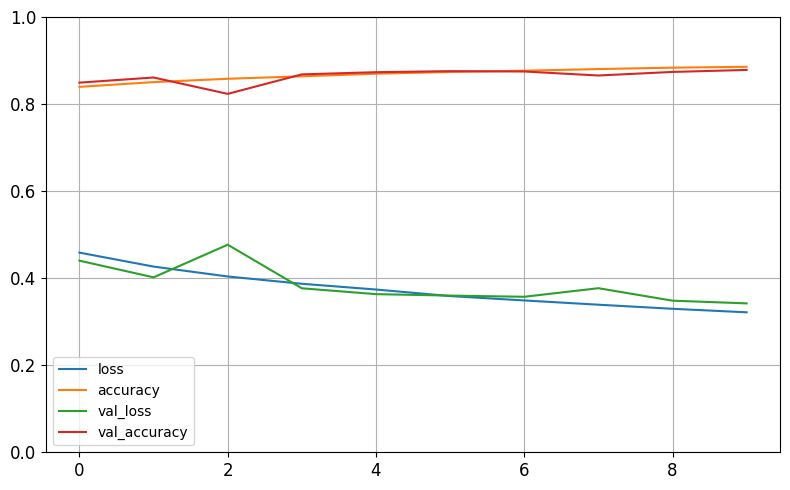

In [40]:
# Colocamos o histórico de treinamento em um dataframe, plotamos e salvamos a figura
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
salva_imagem("plot_keras_learning_curves")
plt.show()

## Avaliando o modelo

Depois de treinar, testamos o modelo com dados de teste.

In [41]:
# Avalia o modelo
modelo.evaluate(X_teste, y_teste)

313/313 [==============================] - 2s 5ms/step - loss: 0.3745 - accuracy: 0.8632


[0.37451058626174927, 0.8632000088691711]

Conseguimos mais de 86% de acurácia em teste. Vamos fazer a previsão de algumas imagens.

In [42]:
# Vamos extrair 5 imagens de teste
X_new = X_teste[:5]

In [43]:
# E então prever a probabilidade de cada classe para cada imagem
y_proba = modelo.predict(X_new)

1/1 [==============================] - 0s 222ms/step


In [44]:
# Previsões de probabilidade
y_proba

array([[1.2343098e-05, 3.6487729e-06, 5.6400153e-05, 4.5585810e-05,
        4.0771670e-06, 4.6282824e-02, 1.6011903e-04, 3.5897505e-02,
        1.1694427e-03, 9.1636813e-01],
       [4.0010946e-05, 2.1987442e-07, 9.9680698e-01, 7.8310279e-07,
        3.3298967e-04, 1.6185620e-10, 2.8185898e-03, 5.2011125e-12,
        4.1839553e-07, 1.2671617e-10],
       [3.4538771e-05, 9.9994838e-01, 2.3477517e-06, 1.0712814e-05,
        3.8609005e-06, 1.3818859e-09, 6.5291182e-08, 6.5547061e-09,
        8.0330814e-08, 2.1572129e-09],
       [9.8693181e-06, 9.9975139e-01, 1.3479291e-05, 2.1480303e-04,
        9.3410526e-06, 7.4810849e-08, 6.1038315e-07, 1.2152209e-07,
        4.8716846e-08, 2.8934787e-07],
       [1.8598641e-01, 9.2033995e-05, 4.9528614e-02, 1.4311216e-03,
        1.7649753e-03, 1.8930995e-06, 7.6061881e-01, 4.8012425e-06,
        5.5272976e-04, 1.8565659e-05]], dtype=float32)

In [45]:
# As previsões de classes são mais fáceis de interpretar
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.04, 0.  , 0.92],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.19, 0.  , 0.05, 0.  , 0.  , 0.  , 0.76, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [48]:
# # Vamos gravar as previsões das 5 imagens
# y_pred = modelo.predict_classes(X_new)
# y_pred

1/1 [==============================] - 0s 53ms/step


array([[1.2343098e-05, 3.6487729e-06, 5.6400153e-05, 4.5585810e-05,
        4.0771670e-06, 4.6282824e-02, 1.6011903e-04, 3.5897505e-02,
        1.1694427e-03, 9.1636813e-01],
       [4.0010946e-05, 2.1987442e-07, 9.9680698e-01, 7.8310279e-07,
        3.3298967e-04, 1.6185620e-10, 2.8185898e-03, 5.2011125e-12,
        4.1839553e-07, 1.2671617e-10],
       [3.4538771e-05, 9.9994838e-01, 2.3477517e-06, 1.0712814e-05,
        3.8609005e-06, 1.3818859e-09, 6.5291182e-08, 6.5547061e-09,
        8.0330814e-08, 2.1572129e-09],
       [9.8693181e-06, 9.9975139e-01, 1.3479291e-05, 2.1480303e-04,
        9.3410526e-06, 7.4810849e-08, 6.1038315e-07, 1.2152209e-07,
        4.8716846e-08, 2.8934787e-07],
       [1.8598641e-01, 9.2033995e-05, 4.9528614e-02, 1.4311216e-03,
        1.7649753e-03, 1.8930995e-06, 7.6061881e-01, 4.8012425e-06,
        5.5272976e-04, 1.8565659e-05]], dtype=float32)

In [49]:
# E então extraímos os nomes das classes associados a cada previsão
np.array(nomes_classes)[y_pred]

IndexError: arrays used as indices must be of integer (or boolean) type

Vamos plotar as previsões.

Salvando a imagem... plot_previsoes_fashion_mnist_images


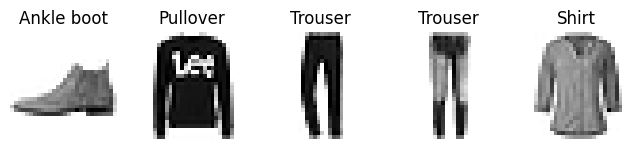

In [50]:
# Plot
plt.figure(figsize = (8, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap = "binary", interpolation = "nearest")
    plt.axis('off')
    plt.title(nomes_classes[y_teste[index]], fontsize = 12)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
salva_imagem('plot_previsoes_fashion_mnist_images', tight_layout = False)
plt.show()